# Validation of model update methods
## model update methods: CORAL, DANN, Self-training, Fine-tuning, Relearning, Proposed method(Partial update method using Score-CAM)

# ------------------------------------------------------------------------------------------

## Prepare

In [1]:
#import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model, load_model

from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Input, Lambda
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
import plotly.express as px
import glob
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import time
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.spatial import distance

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from keras.models import Model
from gradcamutils import GradCam, GradCamPlusPlus, ScoreCam, GuidedBackPropagation, superimpose, read_and_preprocess_img, build_guided_model

from affine_a_method_det import set_deterministic, fit_affine_A_method_deterministic, inverse_transform_ridge, mahalanobis_sq

In [ ]:
#fuction for making label
def create_image_labels(n_light, n_water, n_blackline, n_discoloration, n_dotsonline, n_adhesion, n_scratch):
    """
    function for making label corresponding to each abnormal mode
    
    Args:
        n_light (int): the number of light images
        n_water (int): the number of water images
        n_blackline (int): the number of black line images
        n_discoloration (int): the number of discoloration images
        n_dotsonline (int): the number of dots on line images
        n_adhesion (int): the number of adhesion images
        n_scrtch (int): the number of surface scratches images
    
    Returns:
        pd.DataFrame: 1collumn=image、2collumn=label
    """
    # Name list for each abnormal mode
    light_data = [f"Light-{i}" for i in range(1, n_light + 1)]
    water_data = [f"Water-{i}" for i in range(1, n_water + 1)]
    blackline_data = [f"BlackLine-{i}" for i in range(1, n_blackline + 1)]
    discoloration_data = [f"Discoloration-{i}" for i in range(1, n_discoloration + 1)]
    dotsonline_data = [f"DotsOnLine-{i}" for i in range(1, n_dotsonline + 1)]
    copper_data = [f"Adhesion-{i}" for i in range(1, n_adhesion + 1)]
    spark_data = [f"SurfaceScratch-{i}" for i in range(1, n_scratch + 1)]

    # Label list
    light_labels = [0] * n_light
    water_labels = [1] * n_water
    blackline_labels = [2] * n_blackline
    discoloration_labels = [3] * n_discoloration
    dotsonline_labels = [4] * n_dotsonline
    adhesion_labels = [5] * n_adhesion
    scratch_labels = [6] * n_scratch

    # make dataframe by combining data
    data = list(zip(light_data + water_data + blackline_data + discoloration_data + dotsonline_data + copper_data + spark_data, 
                    light_labels + water_labels + blackline_labels + discoloration_labels + dotsonline_labels + copper_labels + spark_labels))
    df = pd.DataFrame(data, columns=["image", "label"])

    return df

def load_7mode_images(src_dirs):
    """
    src_dirs: list containing full pass of seven folders
              ex: [
                   r"C:/path/mode0/*jpg",
                   r"C:/path/mode1/*jpg",
                   ...
                  ]

    return:
      all_images      :list of all images(cv2) 
      images_by_class : list of each abnormal mode images [list0, list1, ..., list6]
      labels          : list of labels corresponding to each image
      nums            : list of the number of each class images [n0,n1,...,n6]
    """

    assert len(src_dirs) == 7, "Designate 7 folder pass"

    images_by_class = []
    nums = []

    # process
    for i, path in enumerate(src_dirs):
        filepaths = glob.glob(path)
        print(f"Class {i}: {len(filepaths)} files")

        imgs = []
        for fp in filepaths:
            img = cv2.imread(fp)
            if img is not None:
                imgs.append(img)

        images_by_class.append(imgs)
        nums.append(len(imgs))

    # combine
    all_images = []
    for cls_imgs in images_by_class:
        all_images.extend(cls_imgs)

    # make label
    labels = create_image_labels(nums) 

    return all_images, images_by_class, labels, nums

# =========================
# split the data to 7 clusters and make X_clusters / Y_clusters 
# =========================
def prepare_clusters(source_features, target_feature, n_src=240, n_tgt=240, K=7):

    X_all = np.asarray(source_features, dtype=np.float64)
    Y_all = np.asarray(target_feature,   dtype=np.float64)
    if X_all.shape[0] != n_src*K or Y_all.shape[0] != n_tgt*K:
        raise ValueError(f"the number of sample is different: X_all={X_all.shape}, Y_all={Y_all.shape}, Ideal=({n_src*K},{n_tgt*K})")

    X_clusters, Y_clusters = [], []
    for k in range(K):
        X_clusters.append(X_all[k*n_src:(k+1)*n_src])
        Y_clusters.append(Y_all[k*n_tgt:(k+1)*n_tgt])
    return X_clusters, Y_clusters


In [ ]:
#get pass

#wire raw images
#TrainingData
source_dirs = [
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
]
#TestData
source_test_dirs = [
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
]

#bright images
#TrainingData
target1_dirs = [
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
]
#TestData
test_target1_dirs = [
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
]

#camera dust images
#TrainingData
target2_dirs = [
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
]
#TestData
test_target2_dirs = [
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
    r"C:\Users\pass",
]


In [ ]:
#get data and label
source_all_imgs, source_imgs_by_class, source_label, source_num = load_7mode_images(source_dirs)
source_test_all_imgs, source_test_imgs_by_class, source_test_label, source_test_num = load_7mode_images(source_test_dirs)
target1_all_imgs, target1_imgs_by_class, target1_label, target1_num = load_7mode_images(target1_dirs)
test_target1_all_imgs, test_target1_imgs_by_class, test_target1_label, test_target1_num = load_7mode_images(test_target1_dirs)
target2_all_imgs, target2_imgs_by_class, target2_label, target2_num = load_7mode_images(target2_dirs)
test_target2_all_imgs, test_target2_imgs_by_class, test_target2_label, test_target2_num = load_7mode_images(test_target2_dirs)

In [ ]:
#normalization of images
sourcefile_list = [file.astype(float)/255 for file in source_all_imgs]
sourcefile_list = [cv2.resize(file, (360, 270)) for file in sourcefile_list]
sourcefile_test_list = [file.astype(float)/255 for file in source_test_all_imgs]
sourcefile_test_list = [cv2.resize(file, (360, 270)) for file in sourcefile_test_list]
targetfile1_list = [file.astype(float)/255 for file in target1_all_imgs]
targetfile1_list = [cv2.resize(file, (360, 270)) for file in targetfile1_list]
test_targetfile1_list = [file.astype(float)/255 for file in test_target1_all_imgs]
test_targetfile1_list = [cv2.resize(file, (360, 270)) for file in test_targetfile1_list]
targetfile2_list = [file.astype(float)/255 for file in target2_all_imgs]
targetfile2_list = [cv2.resize(file, (360, 270)) for file in targetfile2_list]
test_targetfile2_list = [file.astype(float)/255 for file in test_target2_all_imgs]
test_targetfile2_list = [cv2.resize(file, (360, 270)) for file in test_targetfile2_list]

#numpy list
original_source_label = source_label["label"]
original_source_label = np.array(original_source_label)
original_source_test_label = source_test_label["label"]
original_source_test_label = np.array(original_source_test_label)
original_target1_label = target1_label["label"]
original_target1_label = np.array(original_target1_label)
original_test_target1_label = test_target1_label["label"]
original_test_target1_label = np.array(original_test_target1_label)
original_target2_label = target2_label["label"]
original_target2_label = np.array(original_target2_label)
original_test_target2_label = test_target2_label["label"]
original_test_target2_label = np.array(original_test_target2_label)


#dummy parameter 
source_label = to_categorical(source_label["label"])
source_test_label = to_categorical(source_test_label["label"])
target1_label = to_categorical(target1_label["label"])
test_target1_label = to_categorical(test_target1_label["label"])
target2_label = to_categorical(target2_label["label"])
test_target2_label = to_categorical(test_target2_label["label"])

#change the data to numpy list
#save original data
raw_sourcefile_list = sourcefile_list
raw_sourcefile_test_list = sourcefile_test_list
raw_targetfile1_list = targetfile1_list
raw_test_targetfile1_list = test_targetfile1_list
raw_targetfile2_list = targetfile2_list
raw_test_targetfile2_list = test_targetfile2_list

#numpy list
sourcefile_list = np.array(sourcefile_list)
sourcefile_test_list = np.array(sourcefile_test_list)
targetfile1_list = np.array(targetfile1_list)
test_targetfile1_list = np.array(test_targetfile1_list)
targetfile2_list = np.array(targetfile2_list)
test_targetfile2_list = np.array(test_targetfile2_list)

In [ ]:
# read base model
base_model = load_model('BaseModel.h5')
# separate feature extractor and output layer
feature_output = base_model.layers[-5].output

# GlobalAveragePooling
pooled_output = layers.GlobalAveragePooling2D()(feature_output)

# make feature extractor from base model
feature_extractor = Model(inputs=base_model.input, outputs=pooled_output)
feature_extractor.summary()

In [ ]:
#reduce the dimension from 1024 to 100
n_comp = 100
pca = PCA(n_components=n_comp, svd_solver='full', random_state=42)
features_pca = pca.fit_transform(source_features)
# mapping data to the pca space made above
target1_features_pca = pca.transform(target1_features)
target2_features_pca = pca.transform(target2_features)
test_features_pca = pca.transform(source_test_features)
test_target1_features_pca = pca.transform(test_target1_features)
test_target2_features_pca = pca.transform(test_target2_features)

# ------------------------------------------------------------------------------------------

## Domain adaptaion methods

### CORAL

In [8]:
# CORAL loss
def coral_loss(source, target):
    d = tf.cast(tf.shape(source)[1], tf.float32)
    source_c = tf.matmul(tf.transpose(source - tf.reduce_mean(source, axis=0)), (source - tf.reduce_mean(source, axis=0)))
    target_c = tf.matmul(tf.transpose(target - tf.reduce_mean(target, axis=0)), (target - tf.reduce_mean(target, axis=0)))
    return tf.reduce_sum(tf.square(source_c - target_c)) / (4 * d * d)

# retrain fully connected layer
fc_input = Input(shape=source_features.shape[1:])
fc = layers.Dense(1024, activation="relu")(fc_input)
fc = layers.Dropout(0.6)(fc)
fc_output = layers.Dense(7, activation='softmax')(fc)
new_fc_model = Model(inputs=fc_input, outputs=fc_output)

new_fc_model.summary()

for i in new_fc_model.layers:
    print(i.name, i.trainable)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 1,056,775
Trainable params: 1,056,775
Non-trainable params: 0
_________________________________________________________________
input_1 True
dense True
dropout True
dense_1 True


In [9]:
#compile
with tf.device('/GPU:0'):
    new_fc_model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9),
                     loss=lambda y_true, y_pred: keras.losses.categorical_crossentropy(y_true, y_pred) + 
                                                 0.001 * coral_loss(source_features, target1_features),
                     metrics=['accuracy'])


#EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20)

X_train, X_val, y_train, y_val = train_test_split(
    source_features, source_label,
    test_size=0.1,         
    stratify=source_label,            
)

#training
history = new_fc_model.fit(X_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])
end_time = time.time()
elapsed_time = end_time - start_time

Train on 1512 samples, validate on 168 samples
Epoch 1/1000
1344/1512 [=========================>....] - ETA: 0s - loss: 6.6934 - accuracy: 0.6868

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1512/1512 [==============================] - 1s 689us/sample - loss: 6.6170 - accuracy: 0.7156 - val_loss: 5.9620 - val_accuracy: 0.9702
Epoch 2/1000
1512/1512 [==============================] - 0s 96us/sample - loss: 5.9216 - accuracy: 0.9821 - val_loss: 5.8666 - val_accuracy: 0.9881
Epoch 3/1000
1512/1512 [==============================] - 0s 95us/sample - loss: 5.8569 - accuracy: 0.9848 - val_loss: 5.8364 - val_accuracy: 0.9881
Epoch 4/1000
1512/1512 [==============================] - 0s 93us/sample - loss: 5.8328 - accuracy: 0.9907 - val_loss: 5.8208 - val_accuracy: 0.9881
Epoch 5/1000
1512/1512 [==============================] - 0s 99us/sample - loss: 5.8148 - accuracy: 0.9947 - val_loss: 5.8108 - val_accuracy: 0.9821
Epoch 6/1000
1512/1512 [==============================] - 0s 98us/sample - loss: 5.8093 - accuracy: 0.9901 - val_loss: 5.8038 - val_accuracy: 0.9881
Epoch 7/1000
1512/1512 [==============================] - 0s 100us/sample - loss: 5.7965 - accuracy: 0.9947 - val_loss

<function matplotlib.pyplot.show(close=None, block=None)>

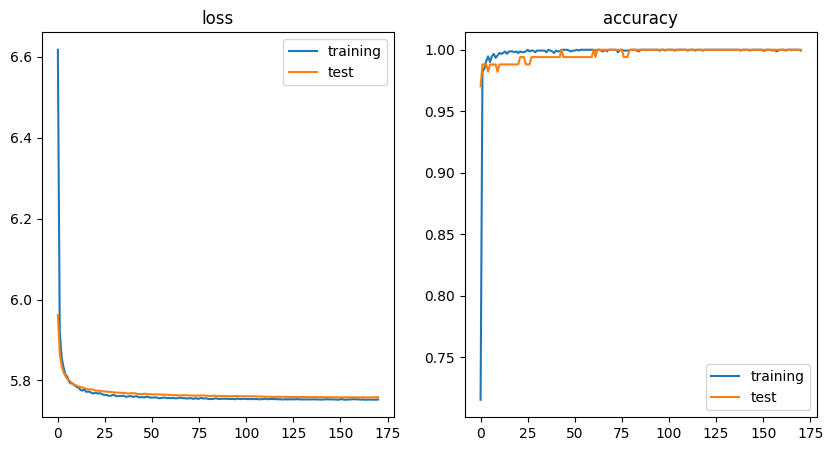

In [10]:
#training curve

metrics = ['loss', 'accuracy']
plt.figure(figsize=(10,5))

for i in range(len(metrics)):
    metric=metrics[i]
    plt.subplot(1,2,i+1)
    plt.title(metric)
    
    plt_train = history.history[metric]
    plt_test = history.history['val_'+metric]
    
    plt.plot(plt_train, label='training')
    plt.plot(plt_test, label='test')
    plt.legend()
    
plt.show

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<Axes: >

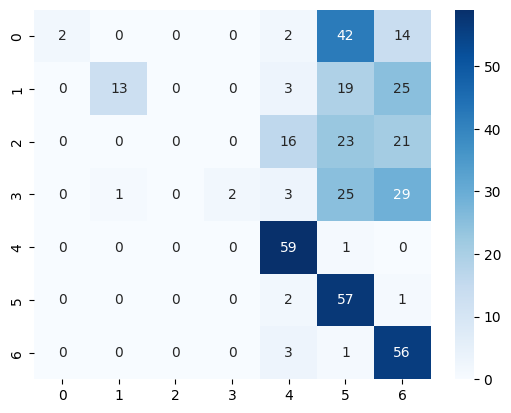

In [11]:
#evaluating updated model
predictions = new_fc_model.predict(test_target1_features, batch_size=8)
results = predictions.argmax(axis = 1)
cm = confusion_matrix(original_test_target1_label, results)
sns.heatmap(cm, annot=True, cmap='Blues')

### DANN

In [8]:
# definition of GradientReversalLayer
class GradientReversalLayer(tf.keras.layers.Layer):
    def __init__(self, lambda_=1.0, **kwargs):
        super().__init__(**kwargs)
        self.lambda_ = tf.Variable(lambda_, trainable=False, dtype=tf.float32)

    def call(self, x):
        @tf.custom_gradient
        def reverse_gradient(x):
            def grad(dy):
                return -self.lambda_ * dy
            return x, grad
        return reverse_gradient(x)

from tensorflow.keras.callbacks import Callback
class LambdaScheduler(Callback):
    def __init__(self, grl_layer, max_lambda=1.0, max_epoch=50):
        super().__init__()
        self.grl_layer = grl_layer
        self.max_lambda = max_lambda
        self.max_epoch = max_epoch

    def on_epoch_begin(self, epoch, logs=None):
        p = epoch / self.max_epoch
        new_lambda = self.max_lambda * (2. / (1. + np.exp(-10 * p)) - 1)
        self.grl_layer.lambda_.assign(new_lambda)
        print(f"Epoch {epoch+1}: GRL lambda updated to {new_lambda:.4f}")

#making DANN model
for layer in feature_extractor.layers:
    layer.trainable = False

for layer in feature_extractor.layers[-14:]:
    layer.trainable = True

inputs = Input(shape = (270,360,3))
features_input = feature_extractor(inputs)
x = Dense(256, activation='relu')(features_input)
x = Dropout(0.5)(x)
classification_output = Dense(7, activation='softmax', name="class_output")(x)

grl_layer = GradientReversalLayer(lambda_=0.0)
reversed_features = grl_layer(features_input)
d = Dense(64, activation='relu')(reversed_features)
d = Dropout(0.5)(d)
domain_output = Dense(1, activation='sigmoid', name="domain_output")(d)

dann_model = Model(inputs=inputs, outputs=[classification_output, domain_output])

#compile
dann_model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9),
                   loss={
        'class_output': 'categorical_crossentropy',
        'domain_output': 'binary_crossentropy'
    },
                   loss_weights={
        'class_output': 1.0,
        'domain_output': 0.1  # ←ドメイン分類器の影響を小さく
    },
                   metrics={
        'class_output': 'accuracy',
        'domain_output': 'accuracy'
    })

for layer in feature_extractor.layers:
    print(layer.name, layer.trainable)

X = np.concatenate([sourcefile_list, targetfile2_240_list], axis=0) 
y_label = np.concatenate([source_label, np.zeros((len(targetfile2_240_list), 7))], axis=0) 
y_domain = np.concatenate([np.zeros((len(sourcefile_list), 1)), np.ones((len(targetfile2_240_list), 1))], axis=0) 
sample_weights = {
    'class_output': np.concatenate([
        np.ones(len(sourcefile_list)),     
        np.zeros(len(targetfile2_240_list))
    ], axis=0).astype('float32'),   

    'domain_output': np.ones(len(sourcefile_list) + len(targetfile2_240_list)).astype('float32')
}



input_1 False
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
conv_dw_8_bn False
conv_dw_8_relu False
conv_pw_8 False
conv_pw_8_bn False
conv_pw_8_relu F

In [9]:
dann_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 270, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 1024)         3228864     ['input_1[0][0]']                
                                                                                                  
 gradient_reversal_layer (Gradi  (None, 1024)        1           ['model[0][0]']                  
 entReversalLayer)                                                                                
                                                                                            

In [10]:
#EarlyStopping
early_stopping = EarlyStopping(monitor='val_class_output_loss', min_delta=0.0001, patience=20)
#LambdaScheduler
lambda_scheduler = LambdaScheduler(grl_layer, max_lambda=1.0, max_epoch=50)

#training
history = dann_model.fit(
    X, [y_label, y_domain],
    sample_weight=sample_weights,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, lambda_scheduler]
)

Train on 3024 samples, validate on 336 samples
Epoch 1: GRL lambda updated to 0.0000
Epoch 1/100
3008/3024 [============================>.] - ETA: 0s - loss: 0.4529 - class_output_loss: 0.3898 - domain_output_loss: 0.6304 - class_output_accuracy: 0.5502 - domain_output_accuracy: 0.6619

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3024/3024 [==============================] - 7s 2ms/sample - loss: 0.4521 - class_output_loss: 0.3886 - domain_output_loss: 0.6278 - class_output_accuracy: 0.5506 - domain_output_accuracy: 0.6634 - val_loss: 0.0585 - val_class_output_loss: 0.0000e+00 - val_domain_output_loss: 0.5880 - val_class_output_accuracy: 0.0000e+00 - val_domain_output_accuracy: 0.7321
Epoch 2: GRL lambda updated to 0.0997
Epoch 2/100
3024/3024 [==============================] - 6s 2ms/sample - loss: 0.1142 - class_output_loss: 0.0774 - domain_output_loss: 0.3718 - class_output_accuracy: 0.5909 - domain_output_accuracy: 0.8347 - val_loss: 0.0454 - val_class_output_loss: 0.0000e+00 - val_domain_output_loss: 0.4540 - val_class_output_accuracy: 0.0000e+00 - val_domain_output_accuracy: 0.8185
Epoch 3: GRL lambda updated to 0.1974
Epoch 3/100
3024/3024 [==============================] - 6s 2ms/sample - loss: 0.0779 - class_output_loss: 0.0487 - domain_output_loss: 0.2903 - class_output_accuracy: 0.5952 - domain_output

<function matplotlib.pyplot.show(close=None, block=None)>

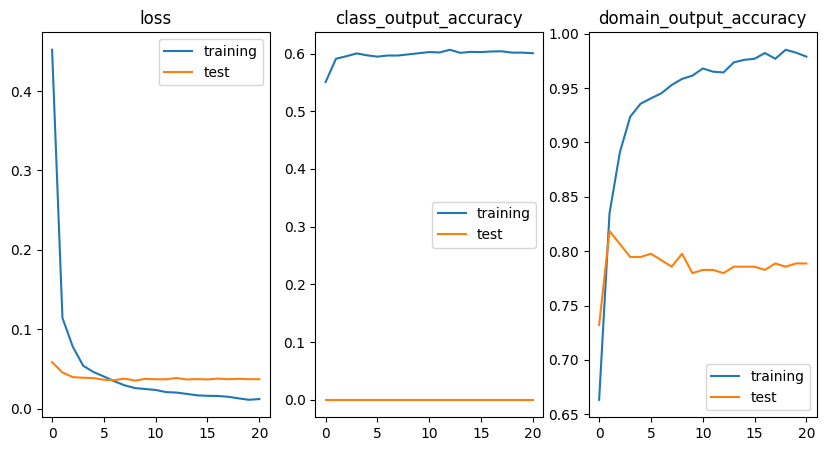

In [11]:
#training curve

metrics = ['loss','class_output_accuracy', 'domain_output_accuracy']

plt.figure(figsize=(10,5))

for i in range(len(metrics)):
    metric=metrics[i]
    plt.subplot(1,3,i+1)
    plt.title(metric)
    
    plt_train = history.history[metric]
    plt_test = history.history['val_' + metric]
    
    plt.plot(plt_train, label='training')
    plt.plot(plt_test, label='test')
    plt.legend()
    
plt.show

<Axes: >

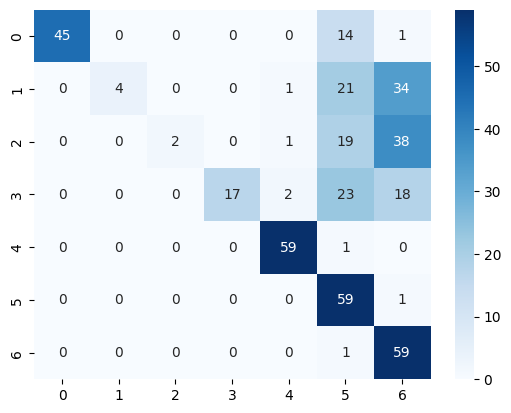

In [12]:
#evaluating updated model
predictions = dann_model.predict(test_targetfile2_60_list, batch_size=8)
results = predictions[0].argmax(axis = 1)
cm = confusion_matrix(original_test_target2_60_label, results)
sns.heatmap(cm, annot=True, cmap='Blues')

### Self-Training

In [8]:
#base model's prediction for drift images
pred_probs = base_model.predict(targetfile1_list)  #prediction possibilities
pred_labels = np.argmax(pred_probs, axis=1)  #prediction label
confidence = np.max(pred_probs, axis=1)  #prediction label's possibility

#choose sample whose confidence is bigger than threshold
threshold = 0.9  
mask = confidence >= threshold
selected_images = targetfile1_list[mask]  
pseudo_labels = pred_labels[mask]  


pseudo_labels_onehot = to_categorical(pseudo_labels, num_classes=7)

#combining raw images and drift images selected
X_train_combined = np.concatenate([sourcefile_list, selected_images])
y_train_combined = np.concatenate([source_label, pseudo_labels_onehot])


for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-17:]:
    layer.trainable = True

#compile
base_model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
conv_dw_8_bn False
conv_dw_8_relu False
conv_pw_8 False
conv_pw_8_bn False
conv_pw_8_relu F

In [9]:
#EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_combined, y_train_combined,
    test_size=0.1,         
    stratify=y_train_combined,            
)

#retraining
history = base_model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_data=(X_val, y_val), callbacks=[early_stopping])

Train on 2637 samples, validate on 294 samples
Epoch 1/1000
2637/2637 [==============================] - ETA: 0s - loss: 0.4133 - accuracy: 0.9427

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2637/2637 [==============================] - 10s 4ms/sample - loss: 0.4133 - accuracy: 0.9427 - val_loss: 0.6546 - val_accuracy: 0.9014
Epoch 2/1000
2637/2637 [==============================] - 6s 2ms/sample - loss: 0.1514 - accuracy: 0.9678 - val_loss: 0.3483 - val_accuracy: 0.9218
Epoch 3/1000
2637/2637 [==============================] - 6s 2ms/sample - loss: 0.1544 - accuracy: 0.9689 - val_loss: 0.4191 - val_accuracy: 0.9082
Epoch 4/1000
2637/2637 [==============================] - 6s 2ms/sample - loss: 0.1173 - accuracy: 0.9719 - val_loss: 0.3775 - val_accuracy: 0.9184
Epoch 5/1000
2637/2637 [==============================] - 6s 2ms/sample - loss: 0.0938 - accuracy: 0.9765 - val_loss: 0.2725 - val_accuracy: 0.9252
Epoch 6/1000
2637/2637 [==============================] - 6s 2ms/sample - loss: 0.0895 - accuracy: 0.9791 - val_loss: 0.2482 - val_accuracy: 0.9252
Epoch 7/1000
2637/2637 [==============================] - 6s 2ms/sample - loss: 0.0732 - accuracy: 0.9803 - val_loss: 0.1794

<function matplotlib.pyplot.show(close=None, block=None)>

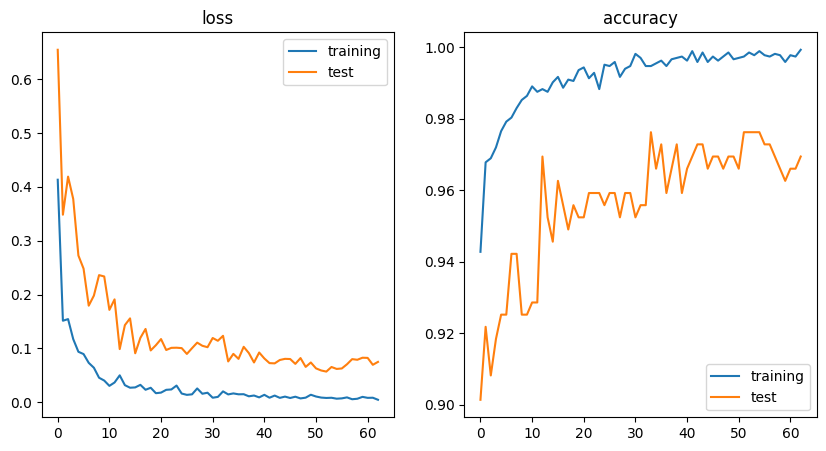

In [10]:
#training curve

metrics = ['loss', 'accuracy']
plt.figure(figsize=(10,5))

for i in range(len(metrics)):
    metric=metrics[i]
    plt.subplot(1,2,i+1)
    plt.title(metric)
    
    plt_train = history.history[metric]
    plt_test = history.history['val_'+metric]
    
    plt.plot(plt_train, label='training')
    plt.plot(plt_test, label='test')
    plt.legend()
    
plt.show

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<Axes: >

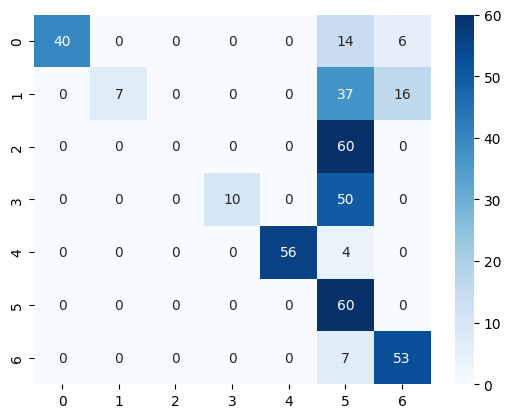

In [11]:
#evaluating updated model
predictions = base_model.predict(test_targetfile1_list, batch_size=8)
results = predictions.argmax(axis = 1)
cm = confusion_matrix(original_test_target1_label, results)
sns.heatmap(cm, annot=True, cmap='Blues')

# ------------------------------------------------------------------------------------------

## Fine-tuning
### Fine-tuning Block12~13+classificaion layer

In [8]:
# --- prepare data ---
X = targetfile1_list
y = target1_label  

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1,
    stratify=y,
    random_state=42
)

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-17:]:
    layer.trainable = True

#compile
base_model.compile(
    optimizer=SGD(learning_rate=1e-3, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

base_model.summary()

for layer in base_model.layers:
    print(layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 270, 360, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 135, 180, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 135, 180, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 135, 180, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 135, 180, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 135, 180, 32)     128       
 ation)                                                      

In [9]:
# --- EarlyStopping ---
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10)

# --- retraining ---
history = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Train on 1512 samples, validate on 168 samples
Epoch 1/1000
1504/1512 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9661

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1512/1512 [==============================] - 4s 3ms/sample - loss: 0.1451 - accuracy: 0.9663 - val_loss: 3.9778 - val_accuracy: 0.5655
Epoch 2/1000
1512/1512 [==============================] - 3s 2ms/sample - loss: 0.0442 - accuracy: 0.9894 - val_loss: 3.0567 - val_accuracy: 0.6250
Epoch 3/1000
1512/1512 [==============================] - 3s 2ms/sample - loss: 0.0212 - accuracy: 0.9907 - val_loss: 2.7503 - val_accuracy: 0.5476
Epoch 4/1000
1512/1512 [==============================] - 3s 2ms/sample - loss: 0.0236 - accuracy: 0.9914 - val_loss: 4.0282 - val_accuracy: 0.5238
Epoch 5/1000
1512/1512 [==============================] - 3s 2ms/sample - loss: 0.0121 - accuracy: 0.9954 - val_loss: 3.7285 - val_accuracy: 0.5179
Epoch 6/1000
1512/1512 [==============================] - 3s 2ms/sample - loss: 0.0147 - accuracy: 0.9960 - val_loss: 3.0397 - val_accuracy: 0.5119
Epoch 7/1000
1512/1512 [==============================] - 3s 2ms/sample - loss: 0.0141 - accuracy: 0.9967 - val_loss: 3.1875 

<function matplotlib.pyplot.show(close=None, block=None)>

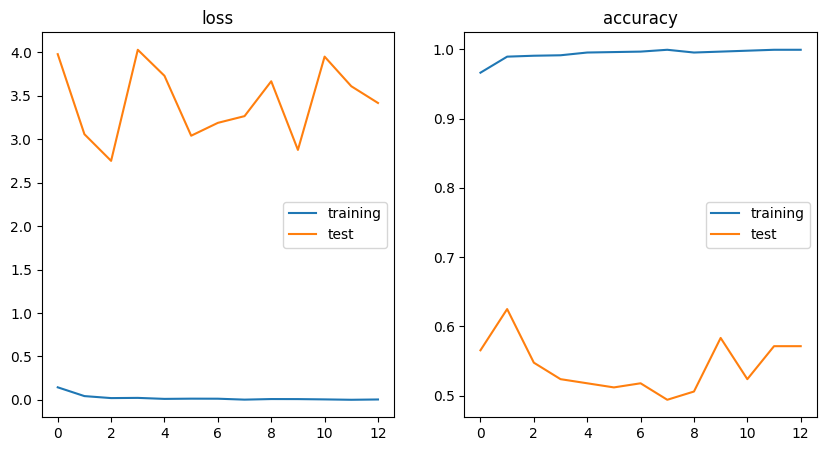

In [10]:
#training curve

metrics = ['loss', 'accuracy']
plt.figure(figsize=(10,5))

for i in range(len(metrics)):
    metric=metrics[i]
    plt.subplot(1,2,i+1)
    plt.title(metric)
    
    plt_train = history.history[metric]
    plt_test = history.history['val_'+metric]
    
    plt.plot(plt_train, label='training')
    plt.plot(plt_test, label='test')
    plt.legend()
    
plt.show

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<Axes: >

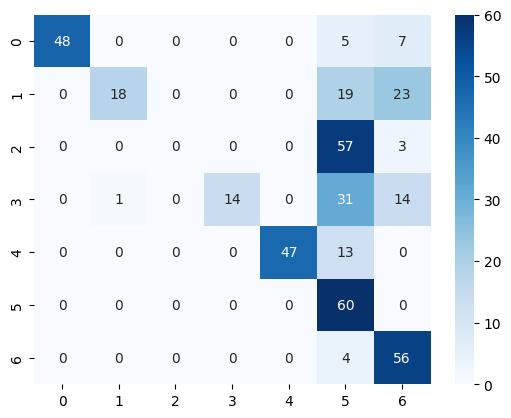

In [11]:
#evaluating updated model
predictions = base_model.predict(test_targetfile1_list, batch_size=8)
results = predictions.argmax(axis = 1)
cm = confusion_matrix(original_test_target1_label, results)
sns.heatmap(cm, annot=True, cmap='Blues')

# ------------------------------------------------------------------------------------------

## Relearning 
### update all network parameters

In [8]:
# --- prepare data ---

X = targetfile1_list
y = target1_label

# --- train/val split ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1,
    stratify=y,
    random_state=42
)

for layer in base_model.layers:
    layer.trainable = True

# --- compile ---
base_model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

base_model.summary()

for layer in base_model.layers:
    print(layer.name, layer.trainable)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 270, 360, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 135, 180, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 135, 180, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 135, 180, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 135, 180, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 135, 180, 32)     128       
 ation)                                                      

In [9]:
# --- EarlyStopping ---
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

# --- retraining ---
history = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

Train on 1512 samples, validate on 168 samples
Epoch 1/200
1512/1512 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9689

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1512/1512 [==============================] - 14s 10ms/sample - loss: 0.1024 - accuracy: 0.9689 - val_loss: 0.1229 - val_accuracy: 0.9643
Epoch 2/200
1512/1512 [==============================] - 12s 8ms/sample - loss: 0.0377 - accuracy: 0.9874 - val_loss: 0.0265 - val_accuracy: 0.9940
Epoch 3/200
1512/1512 [==============================] - 12s 8ms/sample - loss: 0.0202 - accuracy: 0.9934 - val_loss: 0.0347 - val_accuracy: 0.9940
Epoch 4/200
1512/1512 [==============================] - 12s 8ms/sample - loss: 0.0326 - accuracy: 0.9907 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 5/200
1512/1512 [==============================] - 12s 8ms/sample - loss: 0.0172 - accuracy: 0.9960 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 6/200
1512/1512 [==============================] - 12s 8ms/sample - loss: 0.0199 - accuracy: 0.9954 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 7/200
1512/1512 [==============================] - 12s 8ms/sample - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.001

<function matplotlib.pyplot.show(close=None, block=None)>

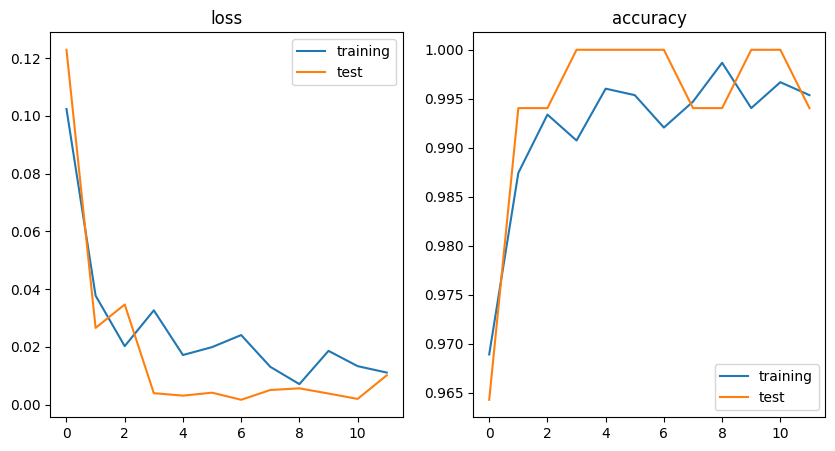

In [10]:
#training curve

metrics = ['loss', 'accuracy']
plt.figure(figsize=(10,5))

for i in range(len(metrics)):
    metric=metrics[i]
    plt.subplot(1,2,i+1)
    plt.title(metric)
    
    plt_train = history.history[metric]
    plt_test = history.history['val_'+metric]
    
    plt.plot(plt_train, label='training')
    plt.plot(plt_test, label='test')
    plt.legend()
    
plt.show

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<Axes: >

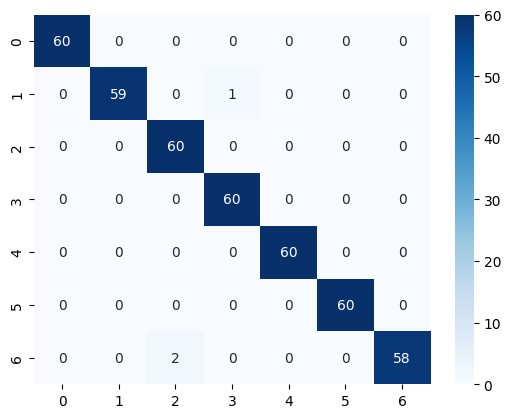

In [11]:
#evaluating updated model
predictions = base_model.predict(test_targetfile1_list, batch_size=8)
results = predictions.argmax(axis = 1)
cm = confusion_matrix(original_test_target1_label, results)
sns.heatmap(cm, annot=True, cmap='Blues')

# ------------------------------------------------------------------------------------------

## Proposed method
### Concatenate High Score Block and update only classification layer

In [8]:
#Choose High Score Block and last block(Block13)
layer_names = ['conv_pw_6_relu','conv_pw_13_relu']
selected_layers = [base_model.get_layer(name).output for name in layer_names]
#mking new model
new_model = keras.Model(inputs = base_model.input, outputs = selected_layers)
x = [layers.GlobalAveragePooling2D()(layer) for layer in selected_layers]
x = layers.concatenate(x, axis = -1)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(7, activation="softmax")(x) 
#making final model
final_model = Model(inputs = new_model.input, outputs = output)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 270, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 135, 180, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 135, 180, 32  128         ['conv1[0][0]']                  
                                )                                                           

In [9]:
#compile
final_model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9), loss = "categorical_crossentropy", metrics = ["accuracy"])

final_model.trainable = True
    
for layer in final_model.layers:
    if not isinstance(layer, Dense):  
        layer.trainable = False
        
for i in final_model.layers:
    print(i.name, i.trainable)

print(final_model.summary())

input_1 False
conv1 False
conv1_bn False
conv1_relu False
conv_dw_1 False
conv_dw_1_bn False
conv_dw_1_relu False
conv_pw_1 False
conv_pw_1_bn False
conv_pw_1_relu False
conv_pad_2 False
conv_dw_2 False
conv_dw_2_bn False
conv_dw_2_relu False
conv_pw_2 False
conv_pw_2_bn False
conv_pw_2_relu False
conv_dw_3 False
conv_dw_3_bn False
conv_dw_3_relu False
conv_pw_3 False
conv_pw_3_bn False
conv_pw_3_relu False
conv_pad_4 False
conv_dw_4 False
conv_dw_4_bn False
conv_dw_4_relu False
conv_pw_4 False
conv_pw_4_bn False
conv_pw_4_relu False
conv_dw_5 False
conv_dw_5_bn False
conv_dw_5_relu False
conv_pw_5 False
conv_pw_5_bn False
conv_pw_5_relu False
conv_pad_6 False
conv_dw_6 False
conv_dw_6_bn False
conv_dw_6_relu False
conv_pw_6 False
conv_pw_6_bn False
conv_pw_6_relu False
conv_dw_7 False
conv_dw_7_bn False
conv_dw_7_relu False
conv_pw_7 False
conv_pw_7_bn False
conv_pw_7_relu False
conv_dw_8 False
conv_dw_8_bn False
conv_dw_8_relu False
conv_pw_8 False
conv_pw_8_bn False
conv_pw_8_relu F

In [10]:
#EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

X_train, X_val, y_train, y_val = train_test_split(
    targetfile1_list, target1_label,
    test_size=0.1,         
    stratify=target1_label,            
)

#retraining
history = final_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Train on 1512 samples, validate on 168 samples
Epoch 1/100
1512/1512 [==============================] - ETA: 0s - loss: 0.9565 - accuracy: 0.6825

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1512/1512 [==============================] - 10s 7ms/sample - loss: 0.9565 - accuracy: 0.6825 - val_loss: 0.4237 - val_accuracy: 0.8929
Epoch 2/100
1512/1512 [==============================] - 8s 5ms/sample - loss: 0.1912 - accuracy: 0.9451 - val_loss: 0.0849 - val_accuracy: 0.9940
Epoch 3/100
1512/1512 [==============================] - 8s 5ms/sample - loss: 0.1044 - accuracy: 0.9683 - val_loss: 0.0386 - val_accuracy: 0.9940
Epoch 4/100
1512/1512 [==============================] - 8s 5ms/sample - loss: 0.0610 - accuracy: 0.9868 - val_loss: 0.0292 - val_accuracy: 0.9940
Epoch 5/100
1512/1512 [==============================] - 8s 5ms/sample - loss: 0.0387 - accuracy: 0.9947 - val_loss: 0.0286 - val_accuracy: 0.9940
Epoch 6/100
1512/1512 [==============================] - 8s 5ms/sample - loss: 0.0348 - accuracy: 0.9901 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 7/100
1512/1512 [==============================] - 8s 5ms/sample - loss: 0.0336 - accuracy: 0.9934 - val_loss: 0.0170 - val

<function matplotlib.pyplot.show(close=None, block=None)>

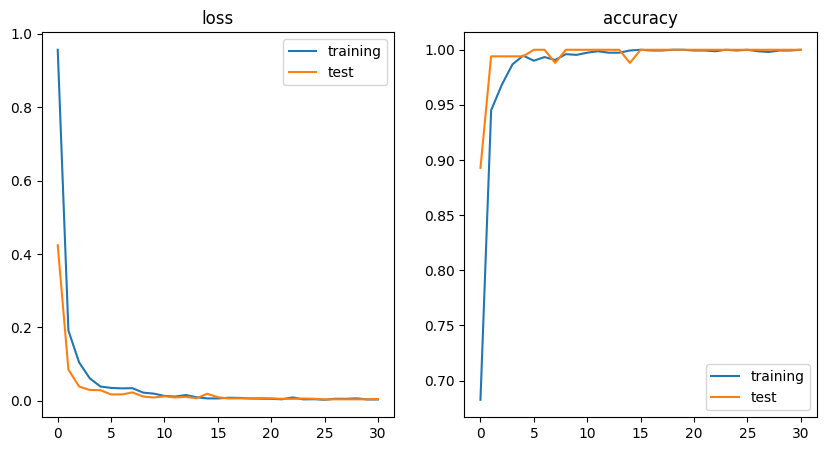

In [11]:
#training curve
metrics = ['loss', 'accuracy']
plt.figure(figsize=(10,5))

for i in range(len(metrics)):
    metric=metrics[i]
    plt.subplot(1,2,i+1)
    plt.title(metric)
    
    plt_train = history.history[metric]
    plt_test = history.history['val_'+metric]
    
    plt.plot(plt_train, label='training')
    plt.plot(plt_test, label='test')
    plt.legend()
    
plt.show

C:\Users\susdesign\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


<Axes: >

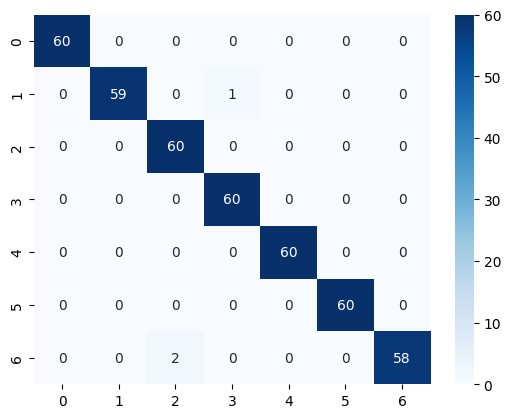

In [12]:
#evaluating updated model
predictions = final_model.predict(test_targetfile1_list, batch_size=8)
results = predictions.argmax(axis = 1)
cm = confusion_matrix(original_test_target1_label, results)
sns.heatmap(cm, annot=True, cmap='Blues')